In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
x = np.linspace(0,50,501)
y = np.sin(x)

In [85]:
df = pd.DataFrame(data=y,index=x,columns=['Sinus'])
df

,Sinus
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


## Répartition Train / Test


Note ! C'est très différent de notre méthodologie habituelle de répartition Entraînement / Test !

In [86]:
len(df)

501

In [87]:
test_percent = 0.1

In [88]:
len(df)*test_percent

50.1

In [89]:
test_point = np.round(len(df)*test_percent) #point coupure

In [90]:
test_point

50.0

In [91]:
test_ind = int(len(df) - test_point)

In [92]:
test_ind

451

In [93]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Mise à l'échelle des données

> Bloc en retrait

In [94]:
from sklearn.preprocessing import MinMaxScaler

In [95]:
scaler = MinMaxScaler()

In [96]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [97]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Phase entrainement

In [98]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [99]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

In [100]:
# définir un générateur
length = 25 # Longueur des séquences de sortie (en nombre de pas temporel)
batch_size = 1 # Nombre d'échantillons de séries temporelles dans chaque batch (lot)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#scaled_train contient les données x et y

In [101]:
len(scaled_train)

451

In [102]:
len(generator) #cet objet generator va generer des batchs de données pour nous
# est scalé train soustrait de la longueur de la séquence

426

In [103]:
# À quoi ressemble le premier batch ?
X,y = generator[0] #premier batch de données

In [104]:
X

array([[[0.49999912],
        [0.54991622],
        [0.59933458],
        [0.64776041],
        [0.69470985],
        [0.73971381],
        [0.78232262],
        [0.82211054],
        [0.85868004],
        [0.89166571],
        [0.92073798],
        [0.94560637],
        [0.9660224 ],
        [0.98178208],
        [0.99272794],
        [0.99875061],
        [0.99978993],
        [0.9958355 ],
        [0.98692684],
        [0.97315296],
        [0.95465148],
        [0.93160726],
        [0.90425056],
        [0.87285471],
        [0.83773342]]])

In [105]:
y

array([[0.79923759]])

In [106]:
print(f"Compte tenu du tableau suivant : \n{X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
[0.49999912 0.54991622 0.59933458 0.64776041 0.69470985 0.73971381
 0.78232262 0.82211054 0.85868004 0.89166571 0.92073798 0.94560637
 0.9660224  0.98178208 0.99272794 0.99875061 0.99978993 0.9958355
 0.98692684 0.97315296 0.95465148 0.93160726 0.90425056 0.87285471
 0.83773342]
Cela prédit ce y : 
 [[0.79923759]]


<Axes: >

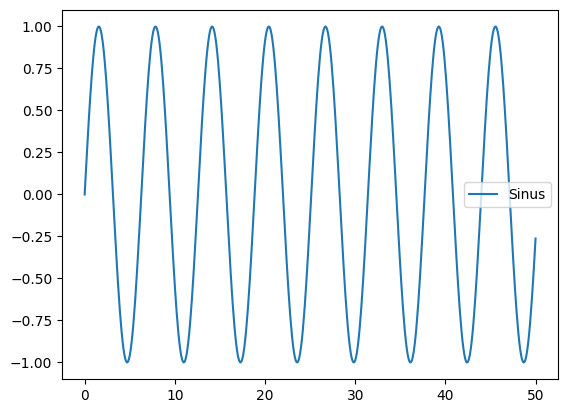

In [107]:
df.plot()

In [108]:
# Redéfinissons pour obtenir 10 pas en arrière et prédisons ensuite le prochain pas en avant
length = 50 # Longueur des séquences de sortie (en nombre de pas temporel)
batch_size = 1 # Le batch_size fait référence au nombre d'exemples de données inclus dans chaque lot d'entraînement.
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#scaled_train contient les données x et y

Vous allez maintenant pouvoir modifier la longueur de manière à ce qu'elle ait un sens pour votre série temporelle !

```
# This is formatted as code
```

## Créer le modèle

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [110]:
n_features = 1

In [111]:
# définir le modèle
model = Sequential()

# Couche simple RNN
model.add(SimpleRNN(50,input_shape=(length,n_features))) #50 neurones

# Prédiction finale
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [113]:
# ajustement du modèle
model.fit(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 2s 3ms/step - loss: 0.0130
Epoch 2/5
401/401 [==============================] - 1s 3ms/step - loss: 7.4884e-05
Epoch 3/5
401/401 [==============================] - 1s 3ms/step - loss: 6.6900e-05
Epoch 4/5
401/401 [==============================] - 1s 3ms/step - loss: 4.0772e-05
Epoch 5/5
401/401 [==============================] - 1s 3ms/step - loss: 5.0365e-04


In [114]:
losses = pd.DataFrame(model.history.history) 
#on peut voir que l'erreur diminue au fur et à mesure des epochs

In [115]:
losses

,loss
0,0.012952
1,0.000075
2,0.000067
3,0.000041
4,0.000504


<Axes: >

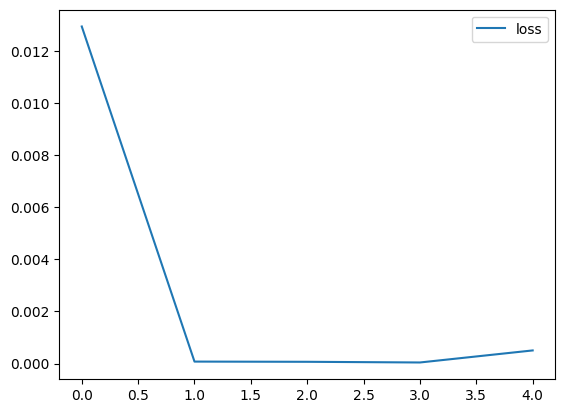

In [116]:
losses.plot() #nous evaluons nos pertes

## Évaluer sur les données de test

> Indented block

In [117]:
# Pensons au premier point batch que je devrai passer dans mon modèle pour prédire quelque chose sur le set de test

first_eval_batch = scaled_train[-length:] #on prend les 50 derniers points de train pour predire le premier point de test

In [118]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) #on reshape pour que le modèle puisse le lire

In [119]:
model.predict(first_eval_batch) #on predit le premier point de test

1/1 [==============================] - 0s 91ms/step


array([[0.94831926]], dtype=float32)

In [120]:
scaled_test[0] #on compare avec le premier point de test

array([0.94955134])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

In [121]:
#boucle pour predire tous les points de test
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))


In [122]:
first_eval_batch

array([[8.37405820e-01],
       [7.98881698e-01],
       [7.57371240e-01],
       [7.13289205e-01],
       [6.67076045e-01],
       [6.19193508e-01],
       [5.70120021e-01],
       [5.20345908e-01],
       [4.70368497e-01],
       [4.20687145e-01],
       [3.71798252e-01],
       [3.24190300e-01],
       [2.78338972e-01],
       [2.34702398e-01],
       [1.93716581e-01],
       [1.55791039e-01],
       [1.21304709e-01],
       [9.06021693e-02],
       [6.39901882e-02],
       [4.17346643e-02],
       [2.40579672e-02],
       [1.11367167e-02],
       [3.10001778e-03],
       [2.81703720e-05],
       [1.95186738e-03],
       [8.85188786e-03],
       [2.06592891e-02],
       [3.72560954e-02],
       [5.84764771e-02],
       [8.41084070e-02],
       [1.13895779e-01],
       [1.47540969e-01],
       [1.84707803e-01],
       [2.25024924e-01],
       [2.68089497e-01],
       [3.13471233e-01],
       [3.60716695e-01],
       [4.09353821e-01],
       [4.58896644e-01],
       [5.08850150e-01],


In [123]:
predicted_value = [[[99]]] #on initialise predicted_value
np.append(current_batch[:,1:,:],[[[99]]],axis=1) #on prend le dernier point de current_batch et on lui ajoute le point suivant de scaled_train

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

In [124]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


In [125]:
test_predictions

[array([0.94831926], dtype=float32),
 array([0.96719307], dtype=float32),
 array([0.9814919], dtype=float32),
 array([0.99126714], dtype=float32),
 array([0.9966616], dtype=float32),
 array([0.9973045], dtype=float32),
 array([0.9942041], dtype=float32),
 array([0.98697275], dtype=float32),
 array([0.9763385], dtype=float32),
 array([0.96256644], dtype=float32),
 array([0.94555485], dtype=float32),
 array([0.92649347], dtype=float32),
 array([0.90480787], dtype=float32),
 array([0.8816724], dtype=float32),
 array([0.8568211], dtype=float32),
 array([0.8307182], dtype=float32),
 array([0.8042176], dtype=float32),
 array([0.7766564], dtype=float32),
 array([0.7493409], dtype=float32),
 array([0.72168297], dtype=float32),
 array([0.69449615], dtype=float32),
 array([0.6680614], dtype=float32),
 array([0.64189273], dtype=float32),
 array([0.6174501], dtype=float32),
 array([0.5935316], dtype=float32),
 array([0.57159275], dtype=float32),
 array([0.5511562], dtype=float32),
 array([0.532060

In [126]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


## Transformations inverses et Comparaison

In [127]:
true_predictions = scaler.inverse_transform(test_predictions)

In [128]:
true_predictions

array([[ 8.96633085e-01],
       [ 9.34380404e-01],
       [ 9.62977887e-01],
       [ 9.82528172e-01],
       [ 9.93317003e-01],
       [ 9.94602784e-01],
       [ 9.88402044e-01],
       [ 9.73939450e-01],
       [ 9.52671134e-01],
       [ 9.25127214e-01],
       [ 8.91104322e-01],
       [ 8.52981854e-01],
       [ 8.09611002e-01],
       [ 7.63340407e-01],
       [ 7.13638281e-01],
       [ 6.61432898e-01],
       [ 6.08432039e-01],
       [ 5.53310106e-01],
       [ 4.98679550e-01],
       [ 4.43364142e-01],
       [ 3.88990956e-01],
       [ 3.36121822e-01],
       [ 2.83784953e-01],
       [ 2.34900119e-01],
       [ 1.87063484e-01],
       [ 1.43186115e-01],
       [ 1.02313393e-01],
       [ 6.41220231e-02],
       [ 3.14732449e-02],
       [ 6.01028442e-04],
       [-2.39708488e-02],
       [-4.56182476e-02],
       [-6.27434782e-02],
       [-7.41594046e-02],
       [-8.36988131e-02],
       [-8.57256527e-02],
       [-8.64111603e-02],
       [-8.12394855e-02],
       [-7.1

In [129]:
test['Predictions'] = true_predictions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4432\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [130]:
test

,Sinus,Predictions
45.1,0.899097,0.896633
45.2,0.938307,0.934380
45.3,0.968142,0.962978
45.4,0.988304,0.982528
45.5,0.998591,0.993317
45.6,0.998900,0.994603
45.7,0.989229,0.988402
45.8,0.969673,0.973939
45.9,0.940429,0.952671
46.0,0.901788,0.925127


<Axes: >

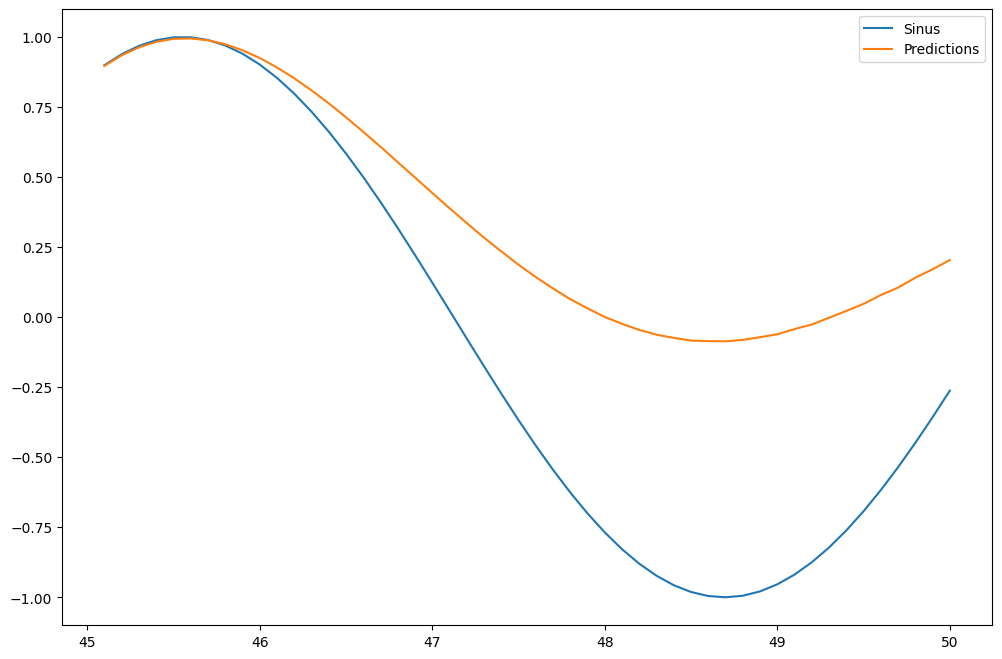

In [131]:
test.plot(figsize=(12,8))